In [ ]:
## Parameters
no_adoption_decline_parameter = 1.0 #  Reasonable probably

# Intermediate steps for calculating the calibrated parameter
kappa_ni = 8.89 / (8.89 - 0.89)
kappa__AV = 8.89 / (8.89 - 0.27 * 0.89)

# Taking the ratio to get the calibrated parameter
full_adoption_decline_parameter = kappa__AV / kappa_ni

alpha = 0.6
sigma = 4.0 
psi   = 0.43 #should estimate from data
local = "/Users/jeffreyohl/Dropbox/SpatialW25/BigDataFiles/"

In [67]:
full_adoption_decline_parameter

0.9248875683549718

# Data 

In [68]:
## Initial API Call
import requests
import pandas as pd
from urllib.parse import quote

def get_county_education_2010():
   api_key = "488b0df48f856b207eae540095aee8cd37926d3a"
   base_url = "https://api.census.gov/data/2010/acs/acs5"
   variables = [
     "B15002_001E",  # Total population 25+
       "B15002_015E",  # Male: Bachelor's degree
       "B15002_016E",  # Male: Master's degree 
       "B15002_017E",  # Male: Professional school degree
       "B15002_018E",  # Male: Doctorate degree
       "B15002_032E",  # Female: Bachelor's degree
       "B15002_033E",  # Female: Master's degree
       "B15002_034E",  # Female: Professional school degree
       "B15002_035E"   # Female: Doctorate degree
    ]
   
   # Build URL
   get_vars = quote(",".join(variables))
   url = f"{base_url}?get=NAME,{get_vars}&for=county:*&in=state:*&key={api_key}"
   
   print(f"Requesting URL: {url}")
   
   try:
       response = requests.get(url)
       print(f"Status code: {response.status_code}")
       
       if response.status_code != 200:
           raise Exception(f"API returned status code {response.status_code}")
           
       # Parse JSON into DataFrame
       data = response.json()
       df = pd.DataFrame(data[1:], columns=data[0])
       
       # Convert to numeric
       for var in variables:
           df[var] = pd.to_numeric(df[var])
           
       # Calculate bachelors or higher (sum male and female)
       df['bachelors_plus'] = (
           df['B15002_015E'] + df['B15002_016E'] + df['B15002_017E'] + df['B15002_018E'] +  # Male
           df['B15002_032E'] + df['B15002_033E'] + df['B15002_034E'] + df['B15002_035E']    # Female
       )
       
       # Calculate percentage
       df['pct_bachelors_plus'] = (df['bachelors_plus'] / df['B15002_001E']).round(8)
       
       # Select and rename columns
       final_df = df[['NAME', 'state', 'county', 'pct_bachelors_plus']]
       
       # Save to CSV
       #final_df.to_csv('county_bachelors_2006_2010.csv', index=False)
       #print("\nSaved to county_bachelors_2006_2010.csv")
       
       return final_df
       
   except requests.exceptions.RequestException as e:
       print(f"Request failed: {e}")
       raise
   except ValueError as e:
       print(f"JSON parsing failed: {e}")
       print(f"Raw response: {response.text}")
       raise

if __name__ == '__main__':
   try:
       county_data = get_county_education_2010()
       print("\nFirst few rows:")
       print(county_data.head())
   except Exception as e:
       print(f"Error: {e}")

Requesting URL: https://api.census.gov/data/2010/acs/acs5?get=NAME,B15002_001E%2CB15002_015E%2CB15002_016E%2CB15002_017E%2CB15002_018E%2CB15002_032E%2CB15002_033E%2CB15002_034E%2CB15002_035E&for=county:*&in=state:*&key=488b0df48f856b207eae540095aee8cd37926d3a
Status code: 200

First few rows:
                                NAME state county  pct_bachelors_plus
0  Las Marías Municipio, Puerto Rico    72    083            0.123230
1  San Germán Municipio, Puerto Rico    72    125            0.196672
2     Comerío Municipio, Puerto Rico    72    045            0.119509
3   Canóvanas Municipio, Puerto Rico    72    029            0.185542
4      Rincón Municipio, Puerto Rico    72    117            0.188367


# Rest of raw data

In [69]:
local + "bilateral_distances.dta"

'/Users/jeffreyohl/Dropbox/SpatialW25/BigDataFiles/bilateral_distances.dta'

In [41]:

import pandas as pd 

import pandas as pd 
# Raw Data.
in_distance = local + "bilateral_distances.dta"
distances = pd.read_stata(in_distance) # note we can't upload this too github it is too big
flows = pd.read_stata("../data/Monte et al 2018 Replication Folder/CMLEE.dta") # i am pulling from esteban's dataset for this
land_area = pd.read_csv('../data/Raw Data/CountyCentroids2010.txt',  # From Census. 
                delimiter='\t',
                encoding='latin-1')
land_area = (
    land_area[['GEOID', 'ALAND']]
    .drop_duplicates()                # remove duplicates based on entire row
    .sort_values(by='GEOID', ascending=True)
)

land_area = land_area[['ALAND', 'GEOID']]



/var/folders/g9/ggrmf_5j6tx4rv5qdhs0slq40000gn/T/ipykernel_57479/2205128217.py:7: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  flows = pd.read_stata("../data/Monte et al 2018 Replication Folder/CMLEE.dta") # i am pulling from esteban's dataset for this


In [42]:
flows

,state_name_res,state_fips_res,state_name_work,state_fips_work,county_name_res,county_name_work,state_county_res,state_county_work,dist,workplace_emp,cz2000_res,cz2000_work,commuting,residence_emp,fr_outsideres,fr_outsidework,avgw_pow
0,Alabama,1,Alabama,1,Autauga County,Mobile County,1001,1097,252.818512,234725,60,254,0.000000,34240.335938,NaN,NaN,40311.371094
1,Alabama,1,Alabama,1,Autauga County,Pickens County,1001,1107,159.675552,6386,60,216,0.000000,34240.335938,NaN,NaN,31380.207031
2,Alabama,1,Oklahoma,40,Autauga County,Tulsa County,1001,40143,940.995728,445827,60,40,0.000000,34240.335938,NaN,NaN,51681.523438
3,Alabama,1,Alabama,1,Autauga County,Franklin County,1001,1059,239.109848,15082,60,140,0.000000,34240.335938,NaN,NaN,30511.404297
4,Alabama,1,Georgia,13,Autauga County,Rabun County,1001,13241,397.059875,8291,60,123,0.000000,34240.335938,NaN,NaN,29258.833984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128723,Wyoming,56,Wyoming,56,Weston County,Crook County,56045,56011,82.572121,4169,445,445,75.924118,5695.854004,NaN,NaN,30836.890625
128724,Wyoming,56,Wyoming,56,Weston County,Niobrara County,56045,56027,87.513115,1741,445,666,15.663063,5695.854004,NaN,NaN,26029.292969
128725,Wyoming,56,Montana,30,Weston County,Big Horn County,56045,30003,290.620361,6368,445,595,0.000000,5695.854004,NaN,NaN,34935.300781
128726,Wyoming,56,Wyoming,56,Weston County,Campbell County,56045,56005,89.891357,32351,445,445,643.807800,5695.854004,NaN,NaN,58798.613281


In [43]:
flows

,state_name_res,state_fips_res,state_name_work,state_fips_work,county_name_res,county_name_work,state_county_res,state_county_work,dist,workplace_emp,cz2000_res,cz2000_work,commuting,residence_emp,fr_outsideres,fr_outsidework,avgw_pow
0,Alabama,1,Alabama,1,Autauga County,Mobile County,1001,1097,252.818512,234725,60,254,0.000000,34240.335938,NaN,NaN,40311.371094
1,Alabama,1,Alabama,1,Autauga County,Pickens County,1001,1107,159.675552,6386,60,216,0.000000,34240.335938,NaN,NaN,31380.207031
2,Alabama,1,Oklahoma,40,Autauga County,Tulsa County,1001,40143,940.995728,445827,60,40,0.000000,34240.335938,NaN,NaN,51681.523438
3,Alabama,1,Alabama,1,Autauga County,Franklin County,1001,1059,239.109848,15082,60,140,0.000000,34240.335938,NaN,NaN,30511.404297
4,Alabama,1,Georgia,13,Autauga County,Rabun County,1001,13241,397.059875,8291,60,123,0.000000,34240.335938,NaN,NaN,29258.833984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128723,Wyoming,56,Wyoming,56,Weston County,Crook County,56045,56011,82.572121,4169,445,445,75.924118,5695.854004,NaN,NaN,30836.890625
128724,Wyoming,56,Wyoming,56,Weston County,Niobrara County,56045,56027,87.513115,1741,445,666,15.663063,5695.854004,NaN,NaN,26029.292969
128725,Wyoming,56,Montana,30,Weston County,Big Horn County,56045,30003,290.620361,6368,445,595,0.000000,5695.854004,NaN,NaN,34935.300781
128726,Wyoming,56,Wyoming,56,Weston County,Campbell County,56045,56005,89.891357,32351,445,445,643.807800,5695.854004,NaN,NaN,58798.613281


In [44]:

### First step is to find the eligible counties for our analysis.

# Use this for calculating data that we have commute flows, etc. on. 
pop_weights = (
    flows[['state_county_res', 'residence_emp']]
    .drop_duplicates()                # remove duplicates based on entire row
    .sort_values(by='state_county_res', ascending=True)
)


# Construct FIPs without leading zeros for consistency with Monte et al code
county_data['FIPS'] = county_data['state'].astype(str) + county_data['county'].astype(str)
county_data['FIPS'] = county_data['FIPS'].str.lstrip('0')
county_data['FIPS']  = county_data['FIPS'].astype(int)
county_data.sort_values(by="FIPS",ascending=True)


# --- Merge Education Data and Population data  -- 
df_merged = county_data.merge(
    pop_weights, 
    left_on='FIPS', 
    right_on='state_county_res', 
    how='inner'
).sort_values('FIPS')


counties_for_inclusion = df_merged.FIPS.unique() # some dont have education data, we can't include those in our analysis

#####

# Only counties in all datasets can be used for analysis, filter down to those (we drop about 1% of counties, not bad)

In [45]:


distances = distances[
    distances['state_county_work'].isin(counties_for_inclusion) &
    distances['state_county_res'].isin(counties_for_inclusion)
]

In [46]:
flows = flows[
    flows['state_county_work'].isin(counties_for_inclusion) &
    flows['state_county_res'].isin(counties_for_inclusion)
]

In [47]:
land_area = land_area[
    land_area['GEOID'].isin(counties_for_inclusion) 
]

# Compute college-shares for later.

In [48]:
# Extract the relevant arrays
pct = df_merged['pct_bachelors_plus'].values
emp = df_merged['residence_emp'].values
# 2) Extract arrays for shares (pct) and employment (emp).
pct = df_merged['pct_bachelors_plus'].to_numpy()
emp = df_merged['residence_emp'].to_numpy()

# 3) Vectorized pairwise workplace-weighted averages:
#    arr[i,j] = (pct[i]*emp[i] + pct[j]*emp[j]) / (emp[i] + emp[j])
numerator   = (pct * emp)[:, None] + (pct * emp)[None, :]
denominator = emp[:, None] + emp[None, :]
scaling = numerator / denominator ## this is the pairwise workplace weighted average of the shares of bachelors degrees, we will use this to scale commute costs.
####
scaling.shape


(3083, 3083)

Mean: 0.9696090521020535
Min: 0.8973884508451606
Max: 0.9946204584665457
Standard Deviation: 0.012394571205951955
Median: 0.972981462476623


# Convert things to np arrays

In [14]:


# 1. Pivot to make each row a unique "res" and each column a unique "work"
pivoted = distances.pivot(
    index='state_county_res',
    columns='state_county_work',
    values='dist'
)

# 2. Sort the index and columns so that the smallest FIPS codes appear first
pivoted = pivoted.sort_index(axis=0).sort_index(axis=1)

# 3. Convert the pivoted DataFrame to a NumPy array
dist_ni = pivoted.to_numpy()

# I am keeping everything in ascending by FIPs order

In [77]:
## Pull key quantities from Esteban's data. 
residence_emp = (
    flows[['state_county_res', 'residence_emp']]
    .drop_duplicates()                # remove duplicates based on entire row
    .sort_values(by='state_county_res', ascending=True)
)


workplace_emp = (
    flows[['state_county_work', 'workplace_emp']]
    .drop_duplicates()                # remove duplicates based on entire row
    .sort_values(by='state_county_work', ascending=True)
)


avgw_pow = (
    flows[['state_county_work', 'avgw_pow']]
    .drop_duplicates()  # remove duplicate rows
    .sort_values(by='state_county_work')
)
land_area = land_area.sort_values(by='GEOID', ascending=True)




In [78]:
workplace_emp

,state_county_work,workplace_emp
13,1001,19141
106,1003,92474
88,1005,14328
14,1007,6685
174,1009,19296
...,...,...
3173,56037,30707
3216,56039,26940
23949,56041,13218
9954,56043,5639


In [16]:
# Vectors we need for the model
workemp   =  np.array(workplace_emp['workplace_emp'])
workwage  = np.array(avgw_pow['avgw_pow'])
    

H_n = np.array(land_area['ALAND'])
    
# Suppose R (residents), D, vbar are also known (random example):
residence_emp    = np.array(residence_emp['residence_emp']) 

In [17]:
len(workemp)

3083

In [18]:
# 1) Compute the pivot table using sum for duplicates (if needed) and fill with 0
df_pivot = flows.pivot_table(
    index='state_county_res',
    columns='state_county_work',
    values='commuting',
    aggfunc='sum',      # sum over duplicates
    fill_value=0
)

# 2) Sort rows and columns in ascending order
df_pivot = df_pivot.sort_index().sort_index(axis=1)

# 3) Divide by the sum of commuting over the entire DataFrame, so each cell becomes a share
total_commuting = flows['commuting'].sum()
df_pivot = df_pivot / total_commuting


lambda_ni = np.array(df_pivot)
lambda_nR = lambda_ni.sum(axis=1)
# Broadcast division over each row using [:, None] to match dimensions
lambda_ni_given_n = lambda_ni / lambda_nR[:, None]   # shape: (N, M)
vbar_n = (lambda_ni_given_n * workwage).sum(axis=1)  # shape: (N,)

# Solve for productivitites

In [19]:
import numpy as np

def rhsProductivities(A, L, w, d, R, D, sigma, vbar):
    """
    Returns an array 'labIncomeHat' of shape (N,), where:
      labIncomeHat[i] = sum_n [
        L[i]*(d[n,i]*w[i]/A[i])^(1-sigma)
        / sum_k [ L[k]*(d[n,k]*w[k]/A[k])^(1-sigma) ]
      ] * [vbar[n]*R[n] + D[n]].

    Parameters
    ----------
    A : array of shape (N,)
        Current guess of A^(sigma-1) or A (depending on usage).
        Make sure A > 0.
    L, w : arrays of shape (N,)
        Employment and wages for each region i.
    d    : (N x N) array with d[n,i] = distance factor from n to i.
    R, D, vbar : arrays of shape (N,)
        R[n], D[n], vbar[n] for region n.
    sigma : float
        Elasticity (> 1).
    
    Returns
    -------
    labIncomeHat : array of shape (N,)
        Model-implied labor income for each i, i.e. the sum over n
        of fraction_{n,i} * (vbar[n]*R[n] + D[n]).
    """
    N = len(A)
    # M[n,i] = L[i]*(d[n,i]*w[i]/A[i])^(1-sigma)
    M = L * np.power(d * (w / A), 1.0 - sigma)  # shape (N, N), numerator
    
    # denom[n] = sum_k M[n,k]
    denom = np.sum(M, axis=1)                   # shape (N,)
    
    # X[n] = vbar[n]*R[n] + D[n]
    X = vbar * R + D                            # shape (N,)
    
    # fraction_{n,i} = M[n,i] / denom[n].
    # partial_term[i,n] = fraction_{n,i} * X[n] => we use transpose.
    M_T = M.T  # shape (N, N), M_T[i,n] = M[n,i]
    summand = (M_T / denom) * X  # broadcast X[n], denom[n]
    labIncomeHat = np.sum(summand, axis=1) # sum over n => shape (N,)
    
    return labIncomeHat


def productivities(
    workemp,      # L_i
    workwage,     # w_i
    resExp,       # dictionary or struct with R, D, vbar
    distmatrix,   # NxN
    sigma,        # elasticity
    psi,          # distance exponent
    detailsYN=True,
    max_iter=1000,
    tol=1e-6
):
    """
    Python version of the Mathematica-style tâtonnement for solving
      w_i L_i == sum_n fraction_{n,i} * [vbar[n]*R[n] + D[n]],
    where fraction_{n,i} = M[n,i]/sum_k M[n,k], M[n,i]=(L_i*(d_{n,i}*w_i/A_i)^(1-sigma)).
    
    We iterate on A^(sigma-1) until the implied w_i L_i matches the actual w_i L_i.
    
    Returns
    -------
    A_final : array of shape (N,) = A_i^(1/(sigma-1)), i.e. the final productivities.
    """

    ncounties = len(workemp)
    
    #------------------------------------------------
    # 1) Preprocess / scaling as per your code
    #    You can adjust these scalings to match your
    #    original Mathematica approach exactly.
    #------------------------------------------------
    
    
    L = workemp  # employees in hundreds
    w = workwage   #wage in tens of thousands thousands

    # Let d = distmatrix^(psi)
    d = distmatrix**psi

    # Unpack R, D, vbar from resExp dict (adjust as needed)
    R = resExp["R"]       # array of shape (N,)
    D_ = resExp["D"]      # array of shape (N,)
    vbar = resExp["vbar"] # array of shape (N,)

    # We'll compute actual "labIncome" = w_i L_i, but note
    # we used w=workwage/1e4 => actual w_i L_i is
    #    (workwage[i]/1e4)*workemp[i] ...
    # If your code wants it in "millions" => divide by 1e6
    # or do whichever scaling you used in Mathematica:
    labIncome = (L * w)  # in
    
    # Step size (partial adjustment)
    lam = 0.990
    
    #------------------------------------------------
    # 2) Initialize A0 as A^(sigma-1) = 1
    #------------------------------------------------
    A0 = np.ones(ncounties)
    
    #------------------------------------------------
    # 3) Iteration
    #------------------------------------------------
    error = 1.0  # track max gap
    c = 0
    
    while error > tol and c < max_iter:
        c += 1
        
        # Model-implied income under current guess A0
        # Note we pass D_ (because "D" is a python builtin),
        # but just rename it for clarity.
        labIncomeHat = rhsProductivities(A0, L, w, d, R, D_, sigma, vbar)
        print("lab income")
        print(labIncome)
        print("total labor income true")
        print(np.sum(labIncome))
        print("lab income hat")
        print(labIncomeHat)
        print("total lab income hat")
        print(np.sum(labIncomeHat))
        # Compare to actual labIncome => gap[i] = actual[i]/hat[i]
        gap = labIncome / labIncomeHat
       
        # "dist" is the maximum relative difference from 1
        error = np.max(np.abs(gap - 1.0))
        distmin = np.min(np.abs(gap - 1.0))
        
        # Partial update: A1 = [ lam + (1-lam)*gap ] * A0
        A1 = (lam + (1.0 - lam)*gap) * A0
        
        # Rescale so that mean(A1) = 1 (like your code)
        A1_mean = np.mean(A1) 
        A0 = A1 / A1_mean # normalize to mean 1.
        print("mean A0")
        print(np.mean(A0))
        print("A0")
        print(A0)
        # Optional: print diagnostics
        if detailsYN and c % 50 == 1 and error > 0.01:
            print(f"Iteration {c}, max gap={error:8.5f}, min gap={distmin:8.5f}, "
                  f"A0 in [{A0.min():.3e}, {A0.max():.3e}]")
            

    if detailsYN:
        print(f"End of iteration {c}, max gap={error:8.5f}, "
              f"A0 in [{A0.min():.3e}, {A0.max():.3e}]")
    
    #------------------------------------------------
    # 4) Exponentiate back to get true A
    #    A^(1/(sigma-1)) and rescale so mean(...)=1
    #------------------------------------------------
    exponent = 1.0 / (sigma - 1.0)
    A_linear = A0**exponent
    A_linear /= np.mean(A_linear)
    
    return A_linear


# ------------------------------------------------------------------------
# EXAMPLE USAGE (dummy example)
if __name__ == "__main__":
    np.random.seed(0)
    ncounties = len(workemp)
    


    total_vbar_R = np.sum(vbar_n * residence_emp)  # scalar
    total_wage_emp = np.sum(workwage * workemp)  # scalar

    difference = total_vbar_R - total_wage_emp
    # allocate deficits equally. 
    D     = np.zeros(ncounties) - (difference)/ ncounties     # no deficits -- need from Yulia 
    # Put them in resExp
    resExp = {"R": residence_emp, "D": D, "vbar": vbar_n}
    
   
    
    A_solution = productivities(
        workemp=workemp,
        workwage=workwage,
        resExp=resExp,
        distmatrix=dist_ni,
        sigma=sigma,
        psi=psi,
        detailsYN=True,
        max_iter=1000,
        tol=1e-8
    )
    print("\nFinal productivities A:", A_solution)


lab income
[6.40599025e+08 2.90766793e+09 4.67938012e+08 ... 5.81472986e+08
 1.99311006e+08 1.54419001e+08]
total labor income true
8756900399015.042
lab income hat
[1.34130140e+09 7.35428643e+09 1.00756635e+09 ... 3.20226942e+08
 2.12988406e+08 3.14725137e+08]
total lab income hat
8756900698862.605
mean A0
1.0000000000000002
A0
[0.99642721 0.9956036  0.99629528 ... 1.00983163 1.0010167  0.99655795]
Iteration 1, max gap=197.51064, min gap= 0.00017, A0 in [9.917e-01, 2.980e+00]
lab income
[6.40599025e+08 2.90766793e+09 4.67938012e+08 ... 5.81472986e+08
 1.99311006e+08 1.54419001e+08]
total labor income true
8756900399015.042
lab income hat
[1.32350606e+09 7.23777209e+09 9.93718655e+08 ... 3.28064831e+08
 2.12551855e+08 3.09984288e+08]
total lab income hat
8756900698862.603
mean A0
1.0
A0
[0.99369239 0.99204985 0.99342978 ... 1.02010244 1.0028218  0.99396396]
lab income
[6.40599025e+08 2.90766793e+09 4.67938012e+08 ... 5.81472986e+08
 1.99311006e+08 1.54419001e+08]
total labor income tru

In [75]:

# Save lambda_ni as lambda_ni.csv
df_pivot.to_csv(output_folder_name + "lambda_ni.csv")

In [83]:
D

array([1796660.6159721, 1796660.6159721, 1796660.6159721, ...,
       1796660.6159721, 1796660.6159721, 1796660.6159721])

In [87]:
residence_emp

,state_county_res,residence_emp
0,1001,34240.335938
35,1003,104695.351562
119,1005,13461.859375
154,1007,11974.728516
168,1009,34892.777344
...,...,...
128647,56037,30729.466797
128674,56039,23802.765625
128685,56041,13208.846680
128707,56043,5422.832031


In [96]:
# Save residence_emp as R_n.csv
residence_emp.to_csv(output_folder_name + "R_n.csv", index=False)

# Save D as D_n.csv
pd.DataFrame({'D_n': D, 'state_county_res': residence_emp['state_county_res']}).to_csv(output_folder_name + "D_n.csv", index=False)


In [100]:

output_folder_name = "../output/"

# v bar n
pd.DataFrame({'vbar_n': vbar_n, 'state_county_res': residence_emp['state_county_res']}).to_csv(output_folder_name + "Vbar_n.csv", index=False)


# Save workemp as L_i.csv
workplace_emp.to_csv(output_folder_name + "L_i.csv", index=False)

# Save workwage as w_i.csv
pd.DataFrame({'w_i': workwage, 'state_county_work': workplace_emp['state_county_work']}).to_csv(output_folder_name + "w_i.csv", index=False)



# Save productivities

In [98]:

pd.DataFrame({'A_i': A_solution, 'state_county_work': workplace_emp['state_county_work']}).to_csv(output_folder_name + "productivities.csv", index=False)


In [99]:
A_solution

array([0.97560396, 0.95675144, 0.97286351, ..., 1.16355761, 1.07745363,
       0.99945358])

# Estimating Equation for $\phi$

In [122]:
import numpy as np
import pandas as pd
from linearmodels.iv import IV2SLS
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
# Suppose you already have:
#   lambda_ni: 2D array of shape (N, I)
#   workwage:  1D array of shape (I,) for w_i
#   distm:     2D array of shape (N, I) for dist_{ni}
#   A_solution:1D array of shape (I,) (the excluded instrument)
#   N = number of residence areas, I = number of workplaces

# 1) Build a long-format DataFrame, dropping rows where lambda_ni == 0
rows = []
N, I = lambda_ni.shape
for n in range(N):
   
    for i in range(I):
        if lambda_ni[n, i] > 0:
            rows.append({
                'n': n,  # residence index
                'i': i,  # workplace index
                'log_lambda': np.log(lambda_ni[n, i]),
                'log_wage':   np.log(workwage[i]),
                'log_dist':   np.log(dist_ni[n, i]),
                'log_A_inst':     np.log(A_solution[i])
            })
df = pd.DataFrame(rows)
def demean_two_way(df, y_col, x_cols, id1_col, id2_col, max_iter=100, tol=1e-8):
    """
    Demean variables for two-way fixed effects using iterative method.
    """
    y = df[y_col].copy()
    X = df[x_cols].copy()
    
    # Initialize
    y_prev = y.copy() + 1
    iter_count = 0
    
    while (np.abs(y - y_prev) > tol).any() and iter_count < max_iter:
        y_prev = y.copy()
        
        # Demean with respect to id1
        y = y - y.groupby(df[id1_col]).transform('mean')
        X = X - X.groupby(df[id1_col]).transform('mean')
        
        # Demean with respect to id2
        y = y - y.groupby(df[id2_col]).transform('mean')
        X = X - X.groupby(df[id2_col]).transform('mean')
        
        iter_count += 1
    
    return y, X
y_demean, X_demean = demean_two_way(
    df,
    y_col='log_lambda',
    x_cols=['log_dist'],
    id1_col='n',
    id2_col='i'
)

# Run regression on demeaned variables
X_demean = sm.add_constant(X_demean)  # Add constant
model = sm.OLS(y_demean, X_demean)
results = model.fit()



In [123]:
phi = -results.params['log_dist']
phi

np.float64(3.9797599518994926)

# Estimating Equation for $\epsilon$

In [124]:
df['y'] = df['log_lambda'] + 3.9783*df['log_dist']

# 3) Sweep out fixed effects by demeaning over n. (not sure how sketchy this is)
#    For each residence n, subtract the mean (over i) from every variable.
df['y_demeaned'] = df['y'] - df.groupby('n')['y'].transform('mean')
df['log_wage_demeaned'] = df['log_wage'] - df.groupby('n')['log_wage'].transform('mean')
df['log_A_inst_demeaned'] = df['log_A_inst'] - df.groupby('n')['log_A_inst'].transform('mean')

# 4) Run the 2SLS regression (no constant, since we've already demeaned).
#    y_demeaned = epsilon * log_wage_demeaned + error
#    with log_wage_demeaned instrumented by A_inst_demeaned.
formula = 'y_demeaned ~ 0 + [log_wage_demeaned ~ log_A_inst_demeaned]'
mod = IV2SLS.from_formula(formula, data=df)
res = mod.fit(cov_type='robust')  # Or choose your preferred cov_type
res

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:             y_demeaned   R-squared:                      0.2232
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2232
No. Observations:               44047   F-statistic:                    8807.0
Date:                Fri, Jan 31 2025   P-value (F-stat)                0.0000
Time:                        14:24:03   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                 
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
log_wage_demeaned     3.1358     0.0334     93.846     0.0000      3.0703      3.2013
=====================================================================================

Endogenous: log_wage_demeaned
Instruments: log_A_inst_demeaned
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x16b015590

In [125]:
epsilon = res.params['log_wage_demeaned']
epsilon

np.float64(3.135795041441956)

In [ ]:
import pandas as pd
phi = 3.9797599518994926
epsilon = 3.135795041441956
# Create a DataFrame with the parameters
parameters = pd.DataFrame({
    'Parameter': ['epsilon', 'phi', 'alpha', 'sigma', 'psi'],
    'Value': [epsilon, phi, alpha, sigma, psi]
})

# Define the output file path
output_file_path = output_folder_name + "commuting_parameters.csv"

# Save the DataFrame to a CSV file
parameters.to_csv(output_file_path, index=False)

NameError: name 'phi' is not defined

# B_ni_hat - this is the counterfactual decline we will apply in our counterfactual

In [70]:
params = pd.read_csv(output_folder_name + "commuting_parameters.csv")

In [71]:
epsilon = params[params['Parameter'] == 'epsilon'].iloc[0,1]

In [72]:

import numpy as np


# B_ni_hat = 1.0 - 0.3 * scaling
B_ni_hat = (no_adoption_decline_parameter 
            - (no_adoption_decline_parameter - full_adoption_decline_parameter)*scaling)

# Because scaling is symmetric, we really only need the lower triangle:
B_ni_hat_lower = np.tril(B_ni_hat)

# Now mirror to get a fully symmetric NxN:
B_ni_hat = B_ni_hat_lower + B_ni_hat_lower.T - np.diag(np.diag(B_ni_hat_lower))

# Raise to -epsilon power since we're actually changing $\kappa$
B_ni_hat = np.power(B_ni_hat, -epsilon)

import numpy as np

mean_B_ni_hat = np.mean(B_ni_hat)
min_B_ni_hat = np.min(B_ni_hat)
max_B_ni_hat = np.max(B_ni_hat)
std_B_ni_hat = np.std(B_ni_hat)
median_B_ni_hat = np.median(B_ni_hat)

print(f"Mean: {mean_B_ni_hat}")
print(f"Min: {min_B_ni_hat}")
print(f"Max: {max_B_ni_hat}")
print(f"Standard Deviation: {std_B_ni_hat}")
print(f"Median: {median_B_ni_hat}")

df_B_ni_hat = pd.DataFrame(B_ni_hat, index=df_merged.FIPS, columns=df_merged.FIPS)
output_Bni_hat = local + "B_ni_hat.csv"
df_B_ni_hat.to_csv(output_Bni_hat)


Mean: 1.0508381869693357
Min: 1.0087104035642636
Max: 1.1849591863509679
Standard Deviation: 0.021686627679501823
Median: 1.0447760563837452


## Mapping practice

In [101]:
df_B_ni_hat

FIPS,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,1.053004,1.062704,1.047165,1.045382,1.041356,1.049644,1.046336,1.044022,1.043455,1.045041,...,1.052760,1.058647,1.051479,1.054281,1.053469,1.047479,1.082396,1.049930,1.053942,1.051625
1003,1.062704,1.065902,1.062026,1.061497,1.056798,1.064028,1.061983,1.055975,1.059809,1.061147,...,1.065605,1.066281,1.064705,1.064326,1.065213,1.060268,1.076815,1.063190,1.065605,1.064724
1005,1.047165,1.062026,1.032506,1.028483,1.030762,1.031446,1.029695,1.037757,1.028725,1.028835,...,1.034264,1.053813,1.035190,1.046896,1.040668,1.038657,1.091354,1.037202,1.040274,1.035725
1007,1.045382,1.061497,1.028483,1.023986,1.028526,1.025496,1.025122,1.036432,1.025185,1.024624,...,1.026993,1.051548,1.029520,1.044362,1.035976,1.036454,1.090806,1.033391,1.035003,1.030186
1009,1.041356,1.056798,1.030762,1.028526,1.030090,1.029920,1.029174,1.035674,1.028665,1.028720,...,1.030931,1.043924,1.031666,1.039782,1.034526,1.035351,1.067862,1.033347,1.034034,1.031942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,1.047479,1.060268,1.038657,1.036454,1.035351,1.039467,1.037317,1.039761,1.035568,1.036395,...,1.041720,1.051960,1.041447,1.047382,1.044130,1.041367,1.077488,1.041562,1.044118,1.041682
56039,1.082396,1.076815,1.091354,1.090806,1.067862,1.107505,1.093118,1.062900,1.081224,1.088445,...,1.120999,1.099204,1.110241,1.093213,1.109101,1.077488,1.126604,1.095411,1.113816,1.109870
56041,1.049930,1.063190,1.037202,1.033391,1.033347,1.038145,1.034774,1.039494,1.032638,1.033468,...,1.042709,1.057810,1.041983,1.050764,1.046897,1.041562,1.095411,1.042017,1.047178,1.042428


In [102]:
df_pivot

state_county_work,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
state_county_res,,,,,,,,,,,,,,,,,,,,,
1001,0.000077,0.000000,0.000000,8.921781e-08,0.000000,0.000000,8.309690e-08,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
1003,0.000000,0.000466,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
1005,0.000000,0.000000,0.000062,0.000000e+00,0.000000,0.000001,0.000000e+00,0.000000e+00,3.879876e-08,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
1007,0.000000,0.000000,0.000000,2.944270e-05,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
1009,0.000000,0.000000,0.000000,1.337008e-08,0.000089,0.000000,0.000000e+00,4.208514e-07,0.000000e+00,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.000173,0.000000,0.000000,0.00000,0.000000
56039,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000134,0.000000,0.00000,0.000000
56041,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000073,0.00000,0.000000


Extracting files...
Files successfully downloaded and extracted to county_boundaries


In [110]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

###############################################
# 1) Compute each county’s normalized dot product
###############################################

# Suppose df_B_ni_hat and df_lambda_ni are both 3083×3083,
# indexed by 2010 FIPS codes that may not be zero-padded.
# We first ensure that the index is zero-padded to length 5.

df_B_ni_hat.index = df_B_ni_hat.index.astype(str).str.zfill(5)
df_pivot.index = df_pivot.index.astype(str).str.zfill(5)

df_B_ni_hat.columns = df_B_ni_hat.columns.astype(str).str.zfill(5)
df_pivot.columns = df_pivot.columns.astype(str).str.zfill(5)

scores = []
for county_fips in df_B_ni_hat.index:
    # row-vectors of B and lambda for this county
    B_i = df_B_ni_hat.loc[county_fips].values
    lambda_i = df_pivot.loc[county_fips].values
    
    # dot product
    dotval = np.dot(B_i, lambda_i)
    # normalized by sum of lambda_i
    normval = dotval / lambda_i.sum() if lambda_i.sum() != 0 else np.nan
    
    scores.append((county_fips, normval))

df_scores = pd.DataFrame(scores, columns=["FIPS", "score"])

###############################################
# 2) Load the 2010 County Shapefile
###############################################
# Adjust path to match your environment:
shapefile_path = (
   local + "2010_county_shape_file/" + "tl_2010_us_county10.shp"
)
counties_2010 = gpd.read_file(shapefile_path)


In [111]:
counties_2010

,STATEFP10,COUNTYFP10,COUNTYNS10,GEOID10,NAME10,NAMELSAD10,LSAD10,CLASSFP10,MTFCC10,CSAFP10,CBSAFP10,METDIVFP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,02,013,01419964,02013,Aleutians East,Aleutians East Borough,04,H1,G4020,None,None,None,A,18083148800,20792209033,+55.2437223,-161.9507485,"MULTIPOLYGON (((-162.63769 54.80112, -162.6411..."
1,02,016,01419965,02016,Aleutians West,Aleutians West Census Area,05,H5,G4020,None,None,None,S,11370762625,25190643524,+51.9594469,+178.3388130,"MULTIPOLYGON (((177.44593 52.11133, 177.44302 ..."
2,28,107,00695776,28107,Panola,Panola County,06,H1,G4020,None,None,None,A,1774515519,51767046,+34.3652052,-089.9630654,"POLYGON ((-90.13476 34.22603, -90.13476 34.226..."
3,28,101,00695773,28101,Newton,Newton County,06,H1,G4020,None,None,None,A,1497282694,3879399,+32.4019702,-089.1184115,"POLYGON ((-89.13497 32.57697, -89.13466 32.576..."
4,28,027,00695738,28027,Coahoma,Coahoma County,06,H1,G4020,None,17260,None,A,1430818231,79539470,+34.2286699,-090.6031650,"POLYGON ((-90.59062 33.9869, -90.59473 33.9869..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3216,37,077,01008556,37077,Granville,Granville County,06,H1,G4020,None,None,None,A,1376758990,12765614,+36.2998840,-078.6576338,"POLYGON ((-78.80329 36.17716, -78.80324 36.179..."
3217,37,111,01025836,37111,McDowell,McDowell County,06,H1,G4020,None,None,None,A,1141169175,13956758,+35.6822317,-082.0480292,"POLYGON ((-81.86107 35.69329, -81.86077 35.692..."
3218,27,021,00659456,27021,Cass,Cass County,06,H1,G4020,None,14660,None,A,5235770376,1016739919,+46.9514271,-094.3337731,"POLYGON ((-94.65939 46.8907, -94.65936 46.8920..."
3219,27,057,00659474,27057,Hubbard,Hubbard County,06,H1,G4020,None,None,None,A,2397485927,191360735,+47.0955506,-094.9132898,"POLYGON ((-95.16917 47.15252, -95.16917 47.155..."


In [117]:

# Create a zero-padded FIPS column by concatenating
# STATEFP10 (2 digits) + COUNTYFP10 (3 digits).
counties_2010["FIPS"] = (
    counties_2010["STATEFP10"].str.zfill(2) +
    counties_2010["COUNTYFP10"].str.zfill(3)
)

###############################################
# 3) Merge your scores onto the county geometry
###############################################
df_map = counties_2010.merge(df_scores, on="FIPS", how="left")

###############################################
# 4) Plot a heatmap (choropleth) of the “score”
###############################################

plot_title = "County-Level Heat Map of Weighted Average Amenity Change, for Residents, weights are commute flows $\lambda_{ni | n}$ "

<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
/var/folders/g9/ggrmf_5j6tx4rv5qdhs0slq40000gn/T/ipykernel_57479/2353750704.py:17: SyntaxWarning: invalid escape sequence '\l'
  plot_title = "County-Level Heat Map of Weighted Average Amenity Change, for Residents, weights are commute flows $\lambda_{ni | n}$ "


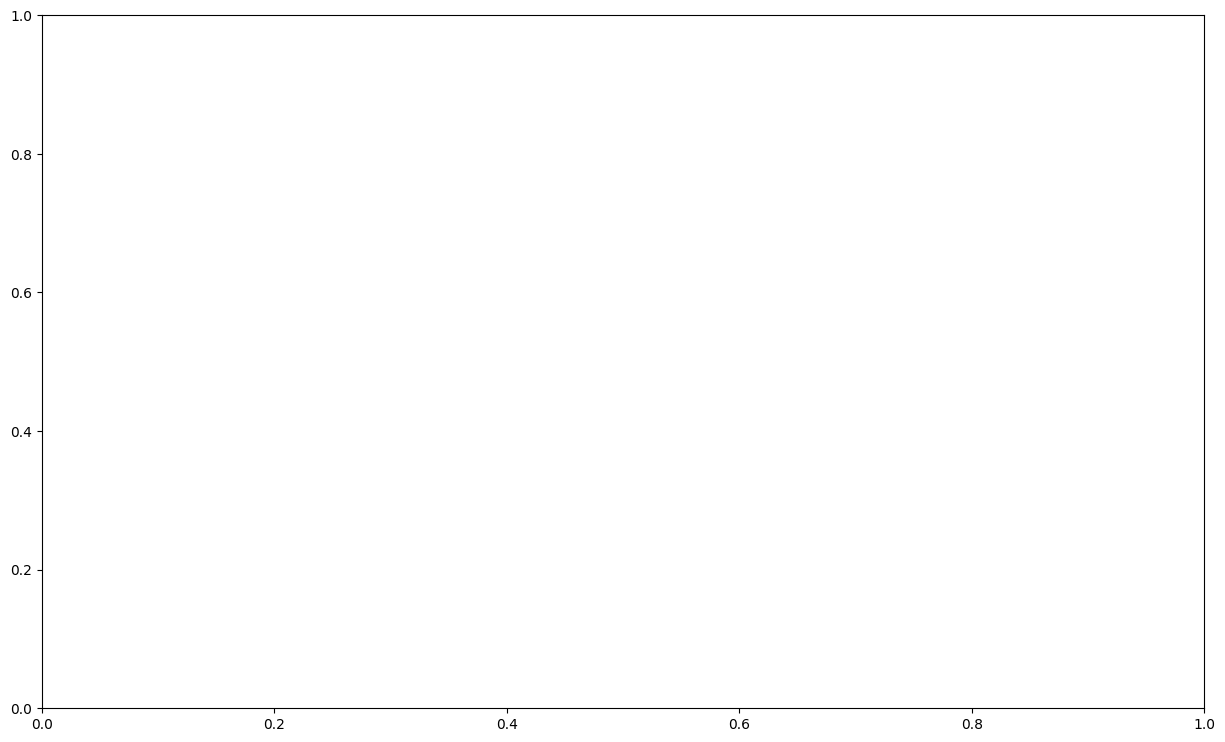

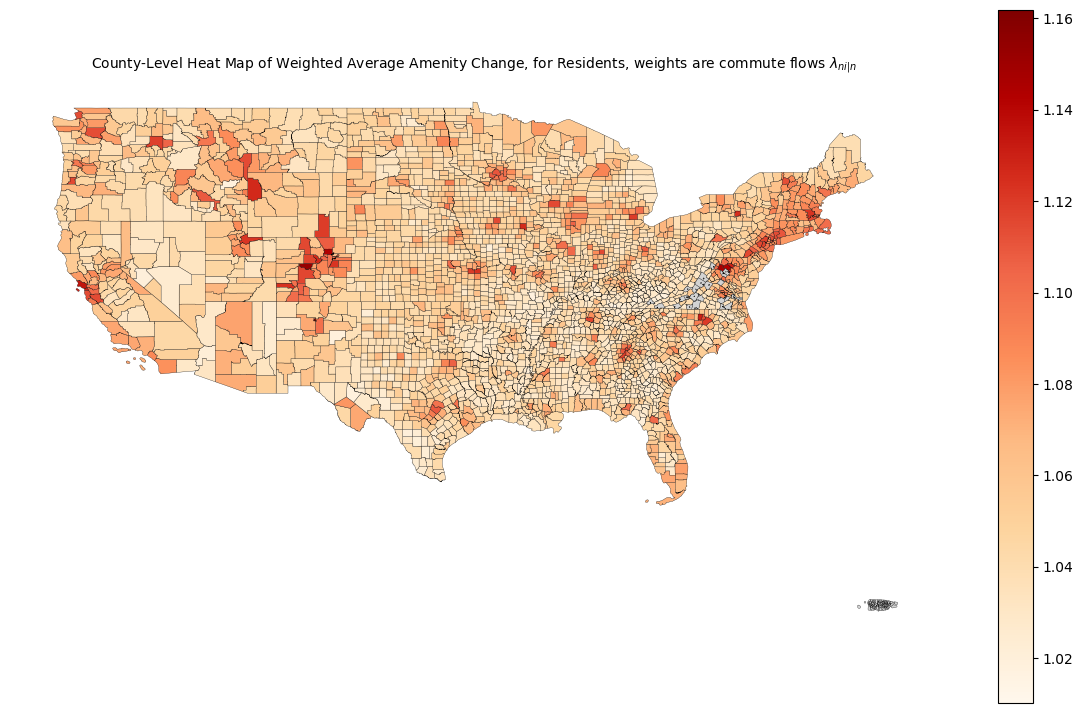

In [127]:
import mapclassify
fig, ax = plt.subplots(1, 1, figsize=(15, 9))

# Exclude AK (02) and HI (15):
lower48 = df_map[~df_map["STATEFP10"].isin(["02", "15"])]

fig, ax = plt.subplots(1, 1, figsize=(15, 9))
lower48.plot(
    column="score",
    ax=ax,
    cmap="OrRd",
    edgecolor="black",
    linewidth=0.2,
    legend=True,
    missing_kwds={"color": "lightgrey"}
)
ax.set_title(plot_title, fontsize=10)
ax.axis("off")

plt.savefig("../output/shocks_by_residence.png", dpi=300, bbox_inches="tight")
plt.show()



In [119]:
%pip install mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 15.5 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
